# MATH 497: Final Project

Remark: 
Please use Jupyter Notebook (Final_Project_yourname.ipynb file) to prepare your final
report, including the output of your code, and submit this on Canvas
by 5pm June 26 Friday EST.

Please summarize your results using Tables, plots and bullet-points
for each problem in a concise, clear and coherent manner.  You are
welcome to organize your presentations using your own style if you
prefer, or you can use the following  as a reference to prepare
your presentation. 

You can also use https://www.tablesgenerator.com/markdown_tables to create your own tables.

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

## Results of Problem 1:


### Task 1

### Show your code for the  Task 1
### Show the plots for the Task 1

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)
    
##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)

    return


##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        
    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
    def forward(self, u, f):
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        return u                                        
    
'''
MODEL SETUP & TESTING
'''
#Plotting functions 
def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()
    
#Kernels setup
RT = nn.ConvTranspose2d(1,1,kernel_size=3,stride=2,padding=0,bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1,1,kernel_size=3,stride=1,padding=1,bias=False)
get_mg_init(A,None,None,None,None)

#MultiGrid Model Setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1

J = 4
M = 100
num_iteration = [2,2,2,2]

MG0 = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f,num_classes)

N = 2**J - 1
f = torch.ones(1,1,N,N)/(N+1)**2
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]
start = timer()
for m in range (M):
    u_list = []
    u = MG0(u,f)
    
    for j in range(J-1,0,-1):
        
        u_list[j] += RT(u_list[j+1])
    
    u = u_list[1]
    
    error.append(np.linalg.norm((A(u)-f).detach().numpy()))
end = timer()
print("Computation Time:", end-start)
plot_error(M, error, "Multigrid")
plot_solution(J, u, "Numerical Solution")

min_error = 10**-5
u = torch.randn(1,1,N,N)             # initial value for u
current_error = np.linalg.norm((A(u)-f).detach().numpy())
iter_count = 0

while(min_error<current_error):
    u_list = []
    u = MG0(u,f)
    
    for j in range(J-1,0,-1):    
        u_list[j] += RT(u_list[j+1])
    
    u = u_list[1]
    
    current_error = np.linalg.norm((A(u)-f).detach().numpy())
    iter_count+=1
print("Number of iterations required to reach minimum error of",min_error,"is",iter_count,"iterations")



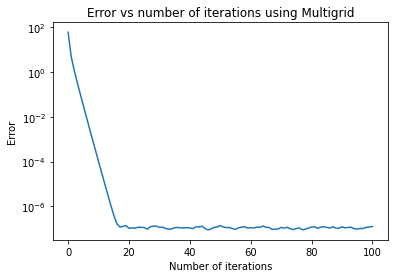

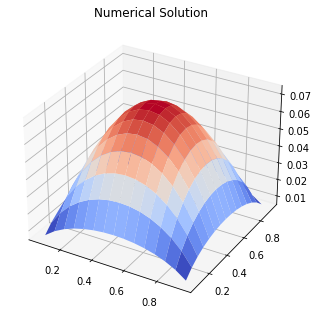

### Task 2

### Show the code for the  Task 2
### Show the plots for the Task 2

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)
    
##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)

    return


##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R
        
    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
    def forward(self, u, f):
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        return u                                        
    
'''
MODEL SETUP & TESTING
'''
#Plotting functions 
def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()
    
#Kernels setup
RT = nn.ConvTranspose2d(1,1,kernel_size=3,stride=2,padding=0,bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1,1,kernel_size=3,stride=1,padding=1,bias=False)
get_mg_init(A,None,None,None,None)

#MultiGrid Model Setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1

J = 4
M = 100
num_iteration = [2,2,2,2]

MG0 = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f,num_classes)

N = 2**J - 1
f = torch.ones(1,1,N,N)/(N+1)**2
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]
start = timer()
for m in range (M):
    u_list = []
    u = MG0(u,f)
    
    for j in range(J-1,0,-1):
        
        u_list[j] += RT(u_list[j+1])
    
    u = u_list[1]
    
    error.append(np.linalg.norm((A(u)-f).detach().numpy()))
end = timer()
print("Computation Time:", end-start)
plot_error(M, error, "Multigrid")
plot_solution(J, u, "Numerical Solution")

min_error = 10**-5
u = torch.randn(1,1,N,N)             # initial value for u
current_error = np.linalg.norm((A(u)-f).detach().numpy())
iter_count = 0

while(min_error<current_error):
    u_list = []
    u = MG0(u,f)
    
    for j in range(J-1,0,-1):    
        u_list[j] += RT(u_list[j+1])
    
    u = u_list[1]
    
    current_error = np.linalg.norm((A(u)-f).detach().numpy())
    iter_count+=1
print("Number of iterations required to reach minimum error of",min_error,"is",iter_count,"iterations")



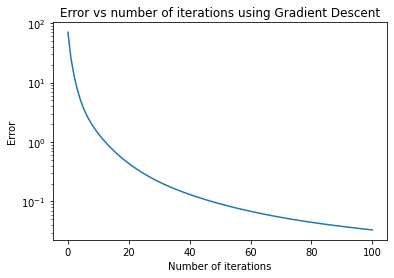

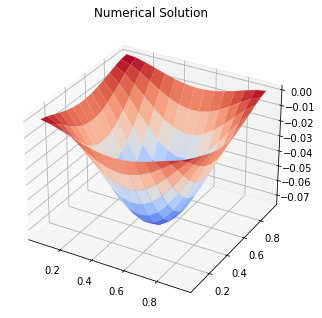

### Task 3

### The following table shows the results of the Task 3:

| Method           | $\nu$ or $\eta$ | #iterations | computational time |
|:-----------------|:-----------|:--------------------|:-------------------|
| Gradient descent |         1/8|                1023 |0.017343338578939438|
| Multigrid        |   [1,1,1,1]|                  13 |  0.1620280034840107|
|                  |            |                     |                    |

### Discussions or Conclusions

#### *  Both the Multigrid Method and the Gradient Descent can achieve similar test accuracy over the same number of epochs
#### *  While the Multigrid Method uses fewer iterations, Gradient Descept takes less computational time

=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

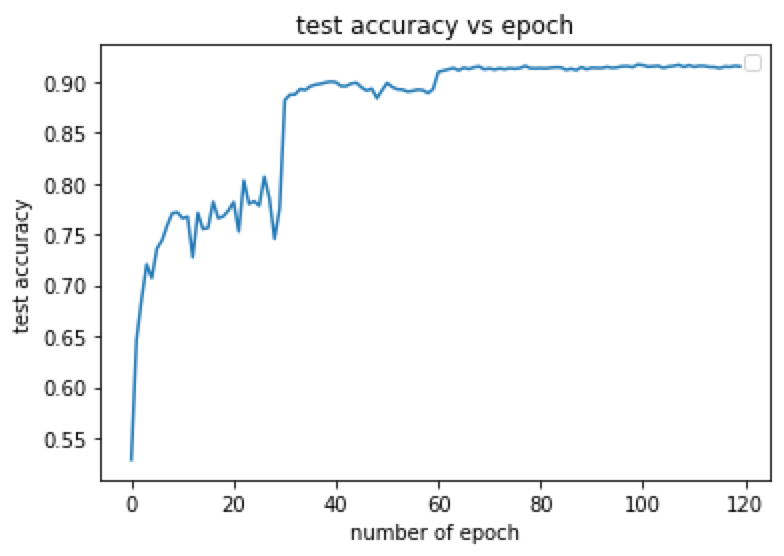

In [ ]:
from IPython.display import Image
Image(filename='plot_sample_code.png')


In [ ]:
# You can calculate the number of parameters of my_model by:
model_size = sum(param.numel() for param in my_model.parameters())


## Results of Problem 2:


### For (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
### For (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.
### For (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, with $S^{l,i}$

### Show your code 
### Show the print and plots 

NOTE: I used a for loop to iterate through all the required models, then used subplots to show them next to each other. Because I used a for loop, I will include the one copy of my code I have for all 3 tasks because I only used one copy of my code to execute every model. Similarly, I will only use one plot that depicts all 3 required subplots. 

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out

        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out

        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old))))+self.A(u)
        
        out = (u,f)
        return out


class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes, s_li):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                if(s_li):
                    S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A

                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        
    
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def test_model(my_model, num_epochs):
    minibatch_size = 128
    
    lr = 0.1
    
    if use_cuda:
        my_model = my_model.cuda()

    # Step 2: Define a loss function and training algorithm
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


    # Step 3: load dataset
    normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

    transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                      torchvision.transforms.RandomHorizontalFlip(),
                                                      torchvision.transforms.ToTensor(),
                                                      normalize])

    transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

    test_acc = []
    # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    start = timer()

    #Step 4: Train the NNs
    # One epoch is when an entire dataset is passed through the neural network only once.
    for epoch in range(num_epochs):
        start_epoch = timer()

        current_lr = adjust_learning_rate(optimizer, epoch, lr)

        start_training = timer()
        my_model.train()
        for i, (images, labels) in enumerate(trainloader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            # Forward pass to get the loss
            outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
            loss = criterion(outputs, labels)

            # Backward and compute the gradient
            optimizer.zero_grad()
            loss.backward()  #backpropragation
            optimizer.step() #update the weights/parameters
        end_training = timer()
        print('Computation Time for training:',end_training - start_training)

      # Training accuracy
        start_training_acc = timer()
        my_model.eval()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(trainloader):
            with torch.no_grad():
                if use_cuda:
                    images = images.cuda()
                    labels = labels.cuda()  
                outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
                p_max, predicted = torch.max(outputs, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum()
        training_accuracy = float(correct)/total
        end_training_acc = timer()
        print('Computation Time for training accuracy:',end_training_acc - start_training_acc)


        # Test accuracy
        start_test_acc = timer()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            with torch.no_grad():
                if use_cuda:
                    images = images.cuda()
                    labels = labels.cuda()  
                outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
                p_max, predicted = torch.max(outputs, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum()
        test_accuracy = float(correct)/total
        test_acc.append(test_accuracy)
        end_test_acc = timer()
        print('Computation Time for test accuracy:',end_test_acc - start_test_acc)

        print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
        end_epoch = timer()
        print('Computation Time for one epoch:',end_epoch - start_epoch)

    end = timer()
    print('Total Computation Time:',end - start)
    return test_acc
num_channel_input = 3
c_u = 64
c_f = 64
num_classes = 10 

num_epochs = 120

v = [[1,1,1,1],[2,2,2,2],[2,2,2,2]]
s_li = [False,False,True]

model_sizes = []
test_accs = []
# Step 1: Define a model
for i in range(len(v)):
    v_i = v[i]
    s_lii = s_li[i]
    my_model = MgNet(num_channel_input, v_i, c_u, c_f, num_classes,s_lii)
    model_size = sum(param.numel() for param in my_model.parameters())
    
    test_acc = test_model(my_model, num_epochs)
    
    model_sizes.append(model_size)
    test_accs.append(test_acc)

epochs = np.arange(0,num_epochs)

f, axs = plt.subplots(2, 2, sharey=True)

axs[0,0].set_title('(1) v = [1,1,1,1]')
axs[0,0].plot(epochs, test_accs[0])

axs[0,1].set_title('(2) v = [2,2,2,2]')
axs[0,1].plot(epochs, test_accs[1])


axs[1,0].set_title('(3) v = [2,2,2,2] and different S per layer')
axs[1,0].plot(epochs, test_accs[2])


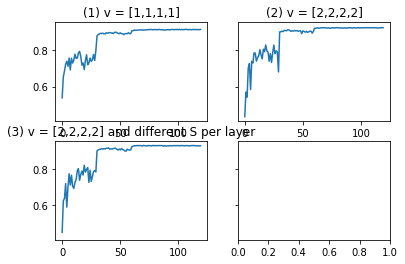

### Summary 

|      Model            | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet with $S^{l}$    |       64,64|  [1,1,1,1] |               0.9165|  5710.011231034994|  520394             |
| MgNet with $S^{l}$    |       64,64|  [2,2,2,2] |               0.9257|  6709.688474295661|  521418             |
| MgNet with $S^{l,i}$  |       64,64|  [2,2,2,2] |               0.9286|  6721.992352753878|  668874     |

### Discussions or Conclusions

#### *  MgNet with $S^{l,i}$ and v = [2,2,2,2]  reaches the highest test accuracy, and also has the most parameters: over 140,000 more parameters than its counterpart
#### * However, the difference in test accuracy between Model 2 and 3 do not suggest that having different $S^{l,i}$ between layers leads to a major difference in test accuracy. I would not recommend using a different $S^{l,i}$  because although it only takes a little more computational time, it is much larger and does not result in a much higher test accuracy

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

## Results of Problem 3:


### Summary 

|                  | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:-----------------|:-----------|:-----------|:--------------------|:------------------|:------------|
|                  |     128,128|   [1,1,1,1]|               0.9289|            5990.16|      2072970         |
|                  |     128,128|   [2,2,2,2]|               0.9405|            7409.26|      2664842       |
|                  |     128,128|   [1,1,2,2]|               0.9317|            6179.55|      2368906       |

### Discussions or Conclusions

#### *  The initial value of v that resulted in the highest test accuracy was [2,2,2,2].This makes sense because v = [2,2,2,2]  led to the highest number of parameters: 2,664,842. Because it had the best resulting test accuracy, its epoch vs. accuracy graph is depicted below. 
#### * It is seen here that choosing a value of v = [2,2,2,2] led to a test accuracy of 0.94, which was extremely close to the desired test accuracy for Problem 4, and given a larger number of epochs, I think it would be possible to achieve a test accuracy of 0.95 with these parameters

### For the best experiment, plot the test accuracy against the epoch count

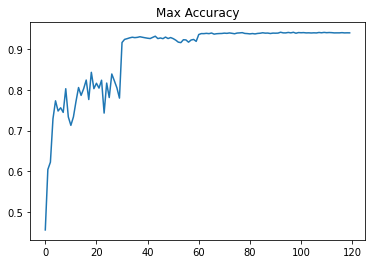

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

## Results of Problem 4:


### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|    |     128,128|  [3,3,3,3]|               0.9522|          4783.2534|     3256714|            N/A            |
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |


### Discussions or Conclusions

#### *  Including more channels increases the number of parameters dramatically. 
#### * The first few times I ran Problem 4, I used the (free)  P5000 GPU. This took over 6 hours to run. Because of the values of c_u, c_f, and v, the computational cost was too much for the free GPU. I switched to (paid) P6000 GPU, and ittook less than 2 hours.

=================================================================================================================

### Summary of all the problems

| Model   | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|   1|       64,64|  [1,1,1,1]|               0.9165|          5710.0012|      520394|                       N/A|
|   2|       64,64|  [2,2,2,2]|               0.9257|          6709.6885|      521418|                       N/A|
|   3|       64,64|  [2,2,2,2]|               0.9286|          6721.9924|      668874|changed $S^{l,i}$ in layer|
|   4|     128,128|  [1,1,1,1]|               0.9289|            5990.16|     2072970|                       N/A|
|   5|     128,128|  [2,2,2,2]|               0.9405|            7409.26|     2664842|                       N/A|
|   6|     128,128|  [1,1,2,2]|               0.9317|            6179.55|     2368906|                       N/A|
|   7|     128,128|  [3,3,3,3]|               0.9522|          4783.2534|     3256714|                       N/A|

### PROBLEM 2:
Models 1,2,3
### PROBLEM 3:
Models 4,5,6
### PROBLEM 4: 
Model 7